In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
def mlxtend_corr(var1, var2):
    p_corr = permutation_test(var1, var2,
                        func=lambda x, y: np.corrcoef(x, y)[0,1],
                        method='approximate',
                        num_rounds=100,
                        seed=42)
    r_corr = np.corrcoef(var1, var2)[0,1]
    return round(p_corr, 4), round(r_corr, 2) 


In [ ]:
dataIn = ''
dataOut = ''

# Phenotypes
phenotype_names = ['age', 'sex', 'handedness', 'BMI', 'education_level', 
       'IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total',
       'BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS', 'NEO_N', 'NEO_E', 'NEO_O',
       'NEO_A', 'NEO_C', 'STAI_T']

In [7]:
def replicability(phen, conn):
    pdis = np.zeros((17, 100))
    prep = np.zeros((17, 100))
    rdis = np.zeros((17, 100))
    rrep = np.zeros((17, 100))

    for perm_row, sampleSize in enumerate(np.arange(25,450, 25)):
        for perm_col in range(100):
        
            ydis = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-ydiscovery_sample-{sampleSize}.npy')
            yhatdis = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yhatdiscovery_sample-{sampleSize}.npy')
            yrep = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yreplication_sample-{sampleSize}.npy')
            yhatrep = np.load(f'{dataIn}/phenotype-{phen}_conntype-{conn}_data-yhatreplication_sample-{sampleSize}.npy')
            
            pdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[0]
            prep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[0]
            
            rdis[perm_row, perm_col] = mlxtend_corr(ydis[:,perm_col], yhatdis[:,perm_col])[1]
            rrep[perm_row, perm_col] = mlxtend_corr(yrep[:,perm_col], yhatrep[:,perm_col])[1]            
            
            
    counts = np.zeros(17)
    effect_sizes = np.zeros((17,2))
    for i in range(17):
        valid_indices = (pdis[i] < 0.05) & (rdis[i] > 0.0)
        counts[i] = np.sum((prep[i][valid_indices] < 0.05) &  (rrep[i][valid_indices] > 0.0) )/np.sum(valid_indices)
        effect_sizes[i,0] = rdis[i][valid_indices].mean()
        effect_sizes[i,1] = rrep[i][valid_indices].mean()
    return counts, effect_sizes[:,0], effect_sizes[:,1]


In [ ]:
replicability_results = []
for conn in range(1):
    results = Parallel(n_jobs=-1)(
        delayed(replicability)(phen, conn)
        for phen in phenotype_names
    )
    replicability_results.append(results)

In [9]:
replicability_results = np.array(replicability_results)

[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.8, '0.8')]

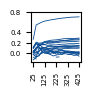

In [10]:
def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')

colormaps = ['Blues']
c = 1
line_width = 0.6
fig, ax = plt.subplots(figsize=(.65,.65))
colormap = plt.get_cmap('Blues')

for i in range(19):
    plt.plot(smooth_array(replicability_results[0][i][2], 2), 
        linewidth=line_width, 
        color=colormap(0.9))

ax.set_xticks([0, 4, 8, 12, 16])
ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
ax.set_yticks([0.0, 0.2, 0.4, 0.8])  # 4 ticks
ax.set_yticklabels([0.0, 0.2, 0.4, 0.8], fontsize=5)

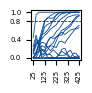

In [11]:
def smooth_array(array, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    return np.convolve(array, np.ones(window_size) / window_size, mode='same')

colormaps = ['Blues']
c = 1
line_width = 0.6
fig, ax = plt.subplots(figsize=(.65,.65))
colormap = plt.get_cmap('Blues')

for i in range(19):
    plt.plot(smooth_array(replicability_results[0][i][0], 2), 
        linewidth=line_width, 
        color=colormap(0.9))

ax.set_xticks([0, 4, 8, 12, 16])
ax.set_xticklabels(np.arange(25, 450, 100), rotation=90, fontsize=5)  
ax.set_yticks([0.0, 0.4, 0.8, 1.0])  # 4 ticks
ax.set_yticklabels([0.0, 0.4, 0.8, 1.0], fontsize=5)
ax.axhline(y=0.8, color='black', linestyle='--', linewidth=0.5)

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'sex'),
 Text(2.5, 0, 'handedness'),
 Text(3.5, 0, 'BMI'),
 Text(4.5, 0, 'education_level'),
 Text(5.5, 0, 'IST_fluid'),
 Text(6.5, 0, 'IST_memory'),
 Text(7.5, 0, 'IST_crystallised'),
 Text(8.5, 0, 'IST_intelligence_total'),
 Text(9.5, 0, 'BAS_drive'),
 Text(10.5, 0, 'BAS_fun'),
 Text(11.5, 0, 'BAS_reward'),
 Text(12.5, 0, 'BIS'),
 Text(13.5, 0, 'NEO_N'),
 Text(14.5, 0, 'NEO_E'),
 Text(15.5, 0, 'NEO_O'),
 Text(16.5, 0, 'NEO_A'),
 Text(17.5, 0, 'NEO_C'),
 Text(18.5, 0, 'STAI_T')]

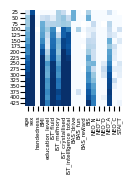

In [12]:
res = []
for i in range(19):
    res.append(replicability_results[0][i][0])
res = np.array(res).T

import seaborn as sns

fig, ax = plt.subplots(figsize=(5/4, 1.25))
sns.heatmap(res, cmap='Blues', cbar=False)
ax.set_yticks(np.arange(0.5, 17.5, 1)) # ticks should be in the center of the box
ax.set_yticklabels(np.arange(25, 450, 25), rotation=0, fontsize=4, ha='center')  
ax.set_xticks(np.arange(0.5, 19.5, 1)) # ticks should be in the center of the box
ax.set_xticklabels(phenotype_names, rotation=90, fontsize=4) 

In [13]:
finalResults = []
for conntype in range(1):
    model_history = np.zeros((19, 3))
    for phenIdx in range(19):
        temp_phen_replicability = np.array(replicability_results[0][phenIdx][0]) #replicability_results[conntype][phenIdx][0]
        start_index = next((i for i, value in enumerate(temp_phen_replicability) if value > 0.8), None)  # correct the code
        #if np.mean(temp_phen_replicability[start_index:]) > 0.8:
        if start_index is not None and np.mean(temp_phen_replicability[start_index:]) > 0.8:
            out_sample_size = np.arange(25, 450, 25)[start_index]
            out_dis_effect_size = replicability_results[conntype][phenIdx][1][start_index]
            out_rep_effect_size = replicability_results[conntype][phenIdx][2][start_index]
        else:
            out_sample_size = np.inf
            out_dis_effect_size = np.inf
            out_rep_effect_size = np.inf
        model_history[phenIdx, 0] = out_sample_size
        model_history[phenIdx, 1] = out_dis_effect_size
        model_history[phenIdx, 2] = out_rep_effect_size
    finalResults.append(model_history)

In [14]:
finalResults = np.array(finalResults)
res_df = pd.DataFrame(finalResults[0])
res_df.index = phenotype_names
res_df.columns = ['Sample Size', 'Discovery Effect Size', 'Replication Effect Size']    
res_df

,Sample Size,Discovery Effect Size,Replication Effect Size
age,250.0,0.171509,0.167170
sex,25.0,0.570714,0.530357
handedness,inf,inf,inf
BMI,200.0,0.211194,0.209552
education_level,inf,inf,inf
IST_fluid,200.0,0.193143,0.201714
IST_memory,375.0,0.140149,0.128358
IST_crystallised,100.0,0.241765,0.219706
IST_intelligence_total,125.0,0.239444,0.214444
BAS_drive,inf,inf,inf


In [15]:
dis_425=[]
rep_425=[]
for i in [0,1,3,5,6,7,8,12,16]:
    dis_425.append(replicability_results[0][i][1][16])
    rep_425.append(replicability_results[0][i][2][16])
dis_425 = np.array(dis_425)
rep_425 = np.array(rep_425)

print(dis_425.min(), dis_425.max(), rep_425.min(), rep_425.max())
print((dis_425 - rep_425).min(), (dis_425 - rep_425).max()    )

0.1294285714285714 0.6857000000000001 0.13314285714285712 0.7070999999999996
-0.050199999999999995 0.00013698630136985135


In [16]:
finite_sample_sizes = res_df[~np.isinf(res_df['Sample Size'])]
finite_sample_sizes.mean()

Sample Size                216.666667
Discovery Effect Size        0.229150
Replication Effect Size      0.216250
dtype: float64